# NYC Taxi Data: Log Transformation and Distribution Analysis

This notebook focuses on applying log transformations to selected skewed features in the NYC taxi dataset. Log transformation is a common technique to reduce skewness in data, making it more suitable for modeling. We will also visualize the distributions of these transformed features.

## Libraries and Initial Setup

We start by importing the necessary libraries and initializing a Spark session.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import log1p, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import DataFrame

In [2]:
# Initialize Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)  # Enable eager evaluation for interactive querying
    .config("spark.sql.parquet.cacheMetadata", "true")  # Cache metadata for parquet files
    .config("spark.sql.session.timeZone", "Etc/UTC")  # Set the timezone to UTC
    .getOrCreate()  # Create or retrieve the existing Spark session
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 13:00:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def shape(sdf: DataFrame) -> None:
    """
    Returns the shape of a Spark DataFrame as a tuple (number of rows, number of columns).

    :param sdf: Spark DataFrame
    :return: String stating the shape of sdf
    """
    num_rows = sdf.count()
    num_columns = len(sdf.columns)
    print(f"Shape of the DataFrame: {num_rows} rows, {num_columns} columns.")

## Load Data

We load the cleaned taxi dataset from a Parquet file into a Spark DataFrame for further processing.

In [4]:
# Load the cleaned taxi data from a Parquet file
sdf = spark.read.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/curated3')
shape(sdf)

Shape of the DataFrame: 4393759 rows, 36 columns.


## Log Transformation of Skewed Features

Log transformation is applied to selected skewed features (`tip_amount`, `trip_duration_mins`, `trip_distance`, `avg_temp`, `precipitation`) to reduce skewness and make the data more normally distributed. A small epsilon value is added to avoid taking the log of zero.

In [5]:
# Apply log transformation to skewed columns to reduce skewness
epsilon = 1e-8  # Small constant to prevent log(0)
sdf_transformed = sdf

# List of columns to apply log transformation
skewed_columns = ['tip_amount', 'trip_duration_mins', 'trip_distance', 'avg_temp', 'precipitation']

# Apply log transformation to each skewed column
for col_name in skewed_columns:
    sdf_transformed = sdf_transformed.withColumn(col_name, log1p(col(col_name) + epsilon))

# Display the first 15 rows of the transformed DataFrame
sdf_transformed.limit(15).show()

24/08/25 13:00:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+---------------------+---------------+------------------+----------+------------------+------------+------------+------------+-----------+-----+-------+--------------------+------------+---------------------+------------+--------------------+-----------+------------------+-----------+----------------+------------+-----------------+---------------------+-------------------------+---------------+---------------+-----------------+------------------+----------------------------+-----------------------------+-----------------+------------+-----------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|     trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|          tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|trip_duration_mins|pickup_hour|pickup_dayofweek|dropoff_hour|dropoff_dayofweek|days_since_2022_11_01|dis

In [6]:
shape(sdf_transformed)

Shape of the DataFrame: 4393759 rows, 36 columns.


The shape of the Dataframe stays the same after the transformations, which is expected.

## Distribution of Log-Transformed Features

We visualize the distribution of the log-transformed features to observe the effect of the transformation on reducing skewness.

In [7]:
sdf_sampled = sdf_transformed.sample(0.1, seed=1003)
df_sample = sdf_sampled.toPandas()

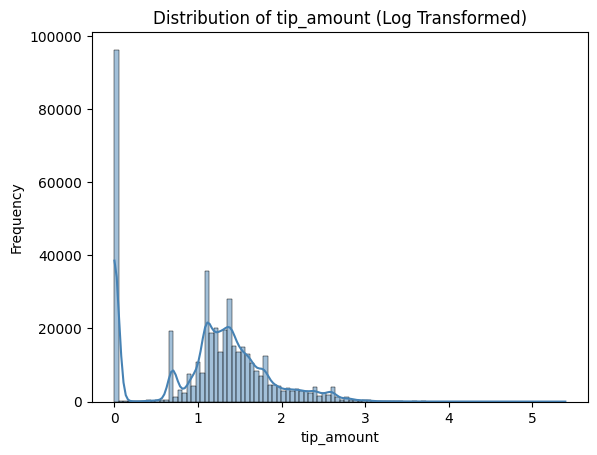

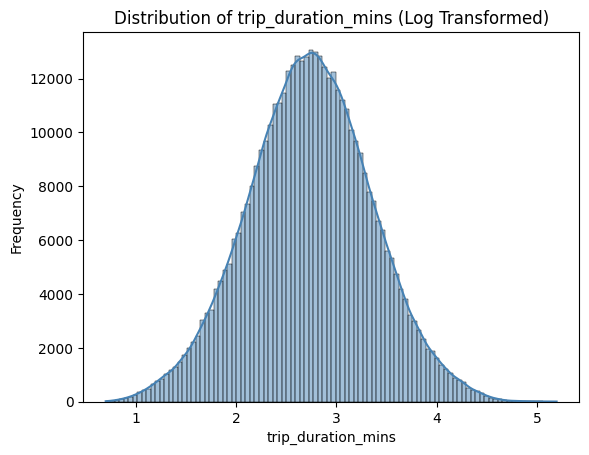

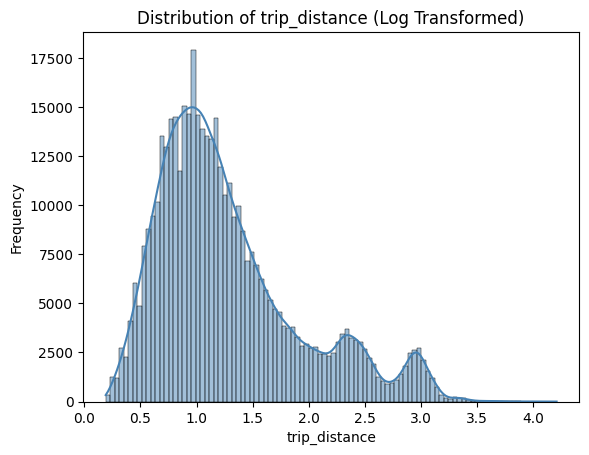

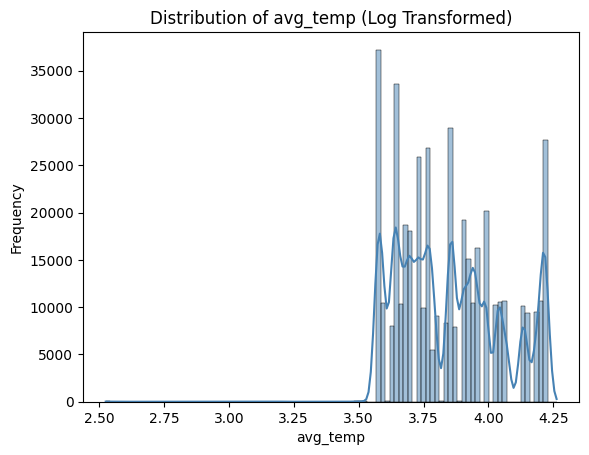

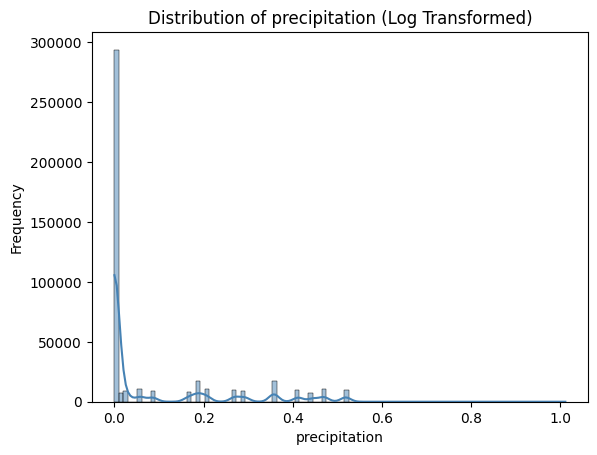

In [8]:
# List of columns to plot after log transformation
columns_to_plot = ['tip_amount', 'trip_duration_mins', 'trip_distance', 'avg_temp', 'precipitation']

# Plot histograms with KDE for each log-transformed feature
for col_name in columns_to_plot:
    sns.histplot(df_sample[col_name], bins=100, kde=True, color='steelblue')
    plt.title(f'Distribution of {col_name} (Log Transformed)')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show()

## Saving Transformed Data

We save the log-transformed DataFrame to a new Parquet file for further analysis or model development.

In [9]:
# Save the log-transformed DataFrame to a new Parquet file
sdf_transformed.write.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development', mode='overwrite')

In [10]:
# Stop the Spark session to release resources
spark.stop()